<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/05_GNN_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks (GAT) Tutorial for Chemists and Pharmacists

## Introduction to Graph Neural Networks and Attention Mechanisms

In this notebook, we'll explore Graph Attention Networks (GAT), a powerful graph neural network architecture particularly useful for molecular data. This tutorial is specifically designed for chemists and pharmacists who want to understand how these models work for molecular property prediction and drug discovery.

## Setup and Requirements

First, let's install the necessary packages:

In [1]:
#@title Intstall necessary libraries
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q rdkit
!pip install -q networkx

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 54.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 22.5 MB/s eta 0:00:00


In [2]:
#@title Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, MessagePassing
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import io
from PIL import Image
import random
from IPython.display import HTML

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Understanding Molecular Graphs

Molecules are naturally represented as graphs where atoms are nodes and bonds are edges. Let's visualize a simple molecule as a graph:

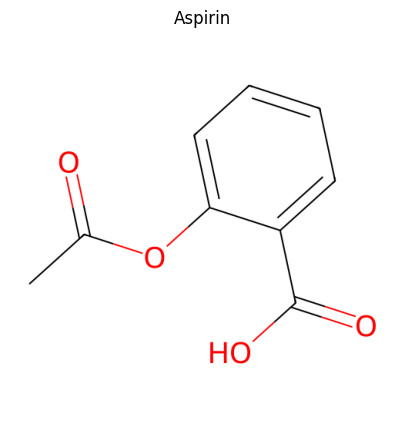

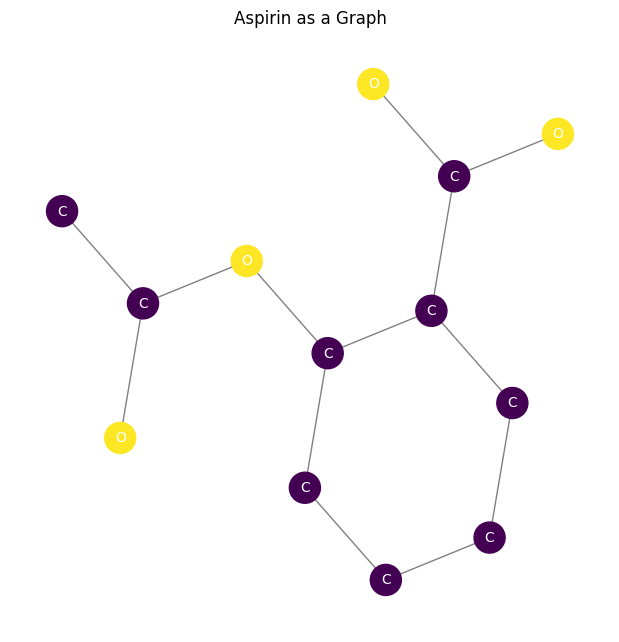

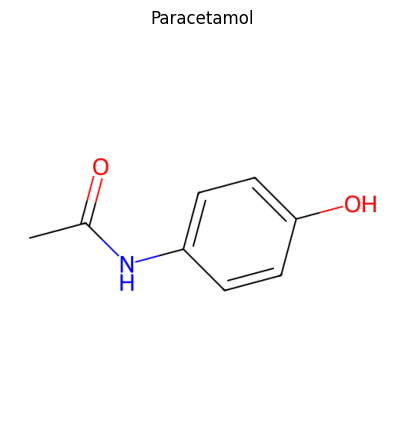

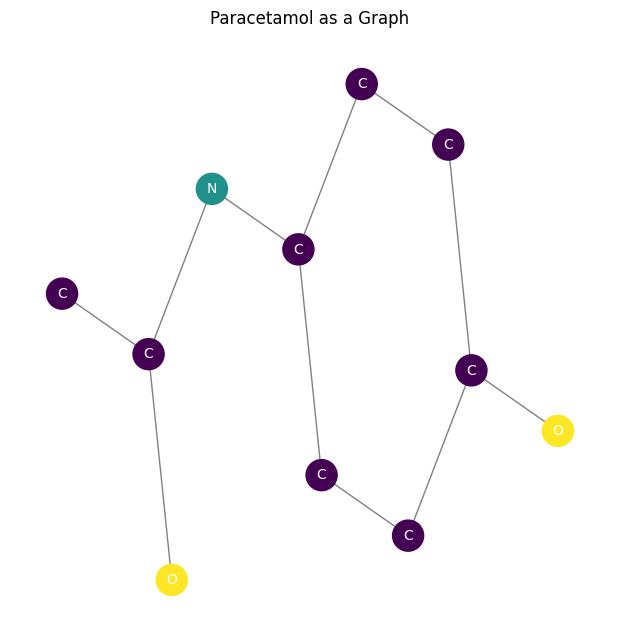

In [3]:
def mol_to_graph(smiles):
    """Convert a SMILES string to a PyTorch Geometric Data object"""
    mol = Chem.MolFromSmiles(smiles)

    # Get node features (atomic numbers as initial features)
    node_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetFormalCharge(),
            atom.GetNumExplicitHs(),
            atom.GetNumImplicitHs(),
            int(atom.GetIsAromatic()),
            atom.GetDegree()
        ]
        node_features.append(features)

    x = torch.tensor(node_features, dtype=torch.float)

    # Get edge indices
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        # Add edges in both directions
        edge_indices.append([i, j])
        edge_indices.append([j, i])

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Get edge features (bond types)
    edge_features = []
    for bond in mol.GetBonds():
        # Add features for both directions
        features = [bond.GetBondTypeAsDouble()]
        edge_features.append(features)
        edge_features.append(features)

    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

def visualize_molecule(smiles, title="Molecule"):
    """Visualize a molecule using RDKit"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    # Draw molecule
    fig, ax = plt.subplots(figsize=(5, 5))
    drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()

    # Convert the image data to a PIL Image
    pil_image = Image.open(io.BytesIO(img))

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def visualize_molecular_graph(smiles, title="Molecular Graph"):
    """Visualize a molecule as a graph using NetworkX"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    data = mol_to_graph(smiles)
    G = to_networkx(data, to_undirected=True)

    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)  # Flip y for better visualization

    plt.figure(figsize=(6, 6))

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Get atom features for node coloring
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]

    # Draw the graph
    nx.draw(G, pos,
            labels=atom_labels,
            with_labels=True,
            node_color=atom_features,
            cmap=plt.cm.viridis,
            node_size=500,
            font_size=10,
            font_color='white',
            edge_color='gray')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Example: Aspirin
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
visualize_molecule(aspirin_smiles, "Aspirin")
visualize_molecular_graph(aspirin_smiles, "Aspirin as a Graph")

# Example: Paracetamol (Acetaminophen)
paracetamol_smiles = "CC(=O)NC1=CC=C(C=C1)O"
visualize_molecule(paracetamol_smiles, "Paracetamol")
visualize_molecular_graph(paracetamol_smiles, "Paracetamol as a Graph")

## 2. Graph Neural Networks: Basic Concepts

Before diving into GATs, let's understand the basic concept of message passing in graph neural networks:

Original node features (first 3 nodes):
tensor([[6., 0., 0., 3., 0., 1.],
        [6., 0., 0., 0., 0., 3.],
        [8., 0., 0., 0., 0., 1.]])

Updated node features after message passing (first 3 nodes):
tensor([[ 2.1835, -0.6335,  2.0354, -0.4598, -3.0335,  2.8583],
        [ 8.5121, -3.9760,  6.8379, -3.6395, -9.1099,  8.9920],
        [ 2.1835, -0.6335,  2.0354, -0.4598, -3.0335,  2.8583]],
       grad_fn=<SliceBackward0>)


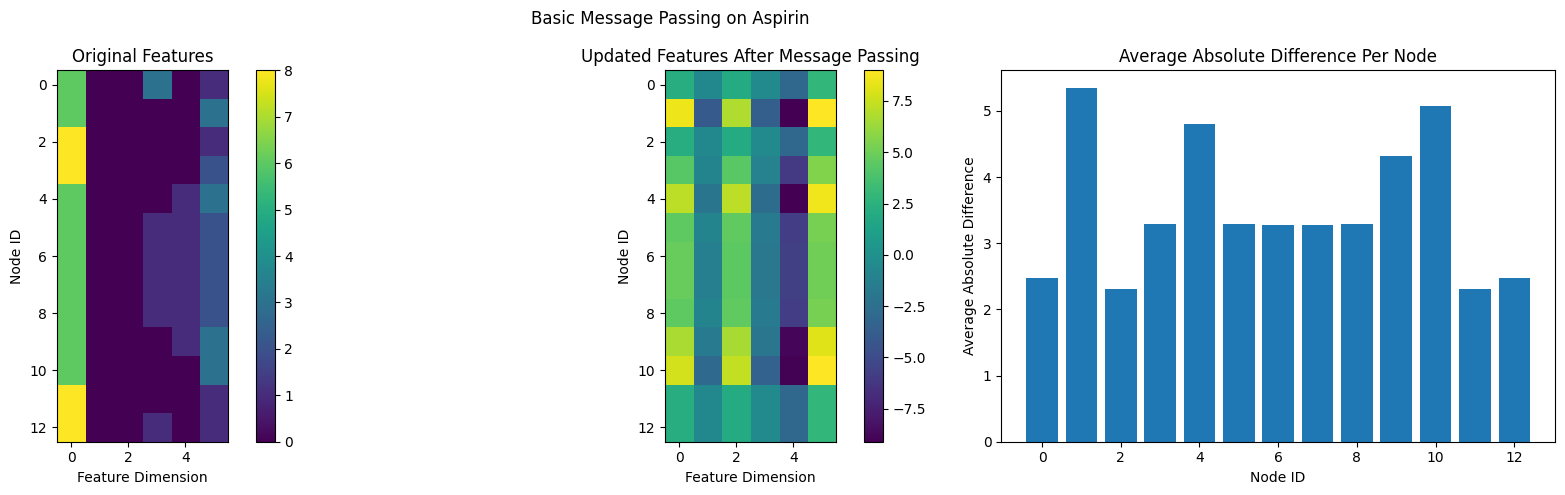

In [4]:
class BasicMessagePassing(MessagePassing):
    """A simple message passing layer for demonstration purposes"""
    def __init__(self, in_channels, out_channels):
        super(BasicMessagePassing, self).__init__(aggr='add')  # "add" aggregation
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Transform node features
        x = self.lin(x)

        # Start propagating messages
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # x_j has shape [E, out_channels]
        # Simple message function that just returns node features
        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # No update function, just return the aggregated messages
        return aggr_out

def simulate_basic_message_passing(data, input_dim=6, output_dim=6):
    """Simulate and visualize the message passing process"""
    # Initialize a simple message passing layer
    mp_layer = BasicMessagePassing(input_dim, output_dim)

    # Original node features
    original_features = data.x

    # Apply message passing
    updated_features = mp_layer(data.x, data.edge_index)

    return original_features, updated_features

# Create a visualization of message passing on aspirin
aspirin_data = mol_to_graph(aspirin_smiles)
orig_feat, updated_feat = simulate_basic_message_passing(aspirin_data)

print("Original node features (first 3 nodes):")
print(orig_feat[:3])
print("\nUpdated node features after message passing (first 3 nodes):")
print(updated_feat[:3])

# Visualize the difference using a heatmap
def plot_feature_comparison(original, updated, title="Feature Comparison"):
    """Plot a comparison of original and updated features"""
    # Compute the difference
    diff = (updated - original).abs().mean(dim=1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot original features
    im1 = ax1.imshow(original.detach().numpy(), cmap='viridis')
    ax1.set_title("Original Features")
    ax1.set_xlabel("Feature Dimension")
    ax1.set_ylabel("Node ID")
    plt.colorbar(im1, ax=ax1)

    # Plot updated features
    im2 = ax2.imshow(updated.detach().numpy(), cmap='viridis')
    ax2.set_title("Updated Features After Message Passing")
    ax2.set_xlabel("Feature Dimension")
    ax2.set_ylabel("Node ID")
    plt.colorbar(im2, ax=ax2)

    # Plot the difference in a separate visualization
    ax3.bar(range(len(diff)), diff.detach().numpy())
    ax3.set_title("Average Absolute Difference Per Node")
    ax3.set_xlabel("Node ID")
    ax3.set_ylabel("Average Absolute Difference")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_feature_comparison(orig_feat, updated_feat, "Basic Message Passing on Aspirin")

## 3. The Attention Mechanism: Why It Matters

Let's compare traditional averaging-based message passing with attention-based message passing:

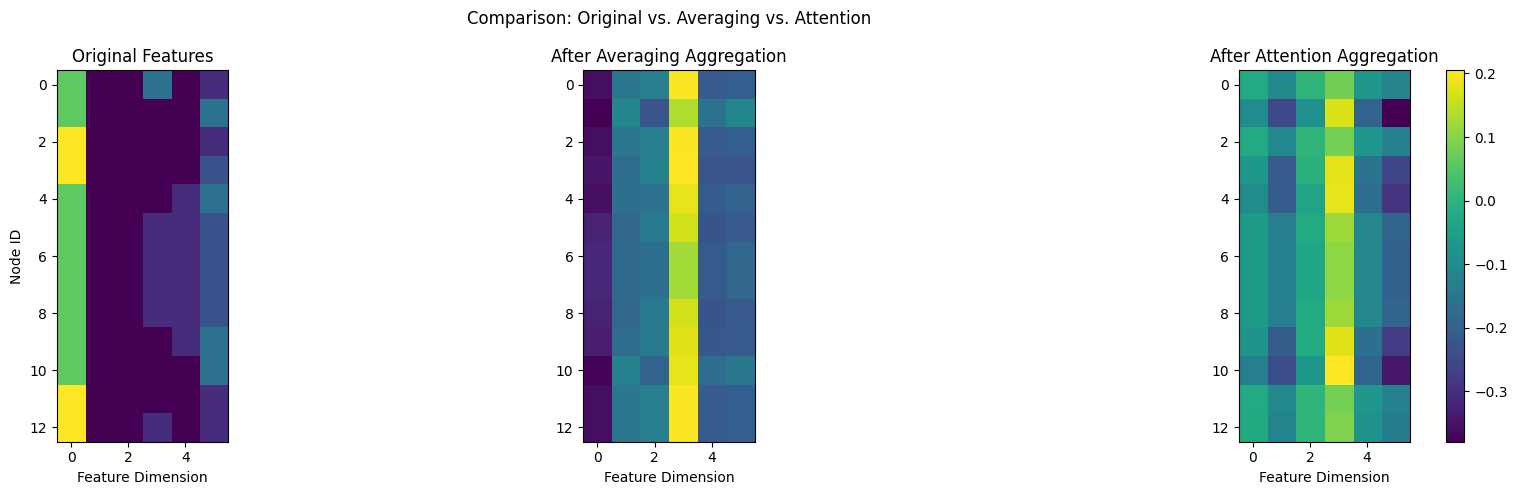

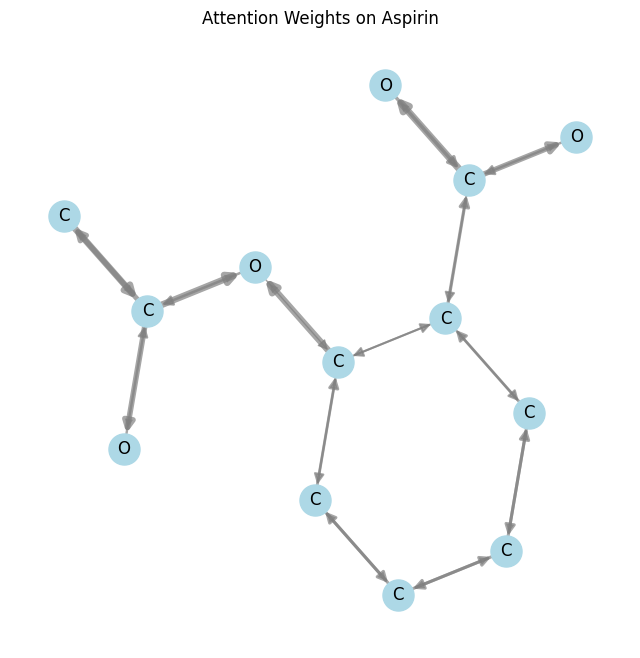

In [8]:
class SimpleAveragingLayer(MessagePassing):
    """A layer that simply averages neighbor features"""
    def __init__(self, in_channels, out_channels):
        super(SimpleAveragingLayer, self).__init__(aggr='mean')  # "mean" aggregation
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Transform node features
        x = self.lin(x)

        # Start propagating messages
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # Simple message function
        return x_j

    def update(self, aggr_out):
        # No update function
        return aggr_out

class SimpleAttentionLayer(MessagePassing):
    """A simplified attention layer for demonstration"""
    def __init__(self, in_channels, out_channels):
        super(SimpleAttentionLayer, self).__init__(aggr='add')
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Linear(2 * out_channels, 1)
        self.alpha = None  # Store attention weights

    def forward(self, x, edge_index, return_attention_weights=False):
        # Transform node features
        x = self.lin(x)

        # Start propagating messages with attention
        out = self.propagate(edge_index, x=x)

        # Return attention weights if requested
        if return_attention_weights:
            return out, (edge_index, self.alpha)
        else:
            return out

    def message(self, x_i, x_j, index):
        # Concatenate features of target and source nodes
        x = torch.cat([x_i, x_j], dim=-1)

        # Compute attention coefficient
        alpha = self.att(x)
        alpha = F.leaky_relu(alpha)

        # Normalize attention coefficients
        alpha = F.softmax(alpha, dim=0)

        # Store attention weights for later use
        self.alpha = alpha

        # Apply attention weights to source features
        return x_j * alpha

    def update(self, aggr_out):
        return aggr_out

def compare_averaging_vs_attention(data, input_dim=6, output_dim=6):
    """Compare averaging vs attention on a molecular graph"""
    # Initialize layers
    avg_layer = SimpleAveragingLayer(input_dim, output_dim)
    att_layer = SimpleAttentionLayer(input_dim, output_dim)

    # Apply both methods
    avg_features = avg_layer(data.x, data.edge_index)
    att_features, (edge_index, att_weights) = att_layer(data.x, data.edge_index, return_attention_weights=True)

    return data.x, avg_features, att_features, att_weights

# Compare on aspirin
original, avg_feat, att_feat, att_weights = compare_averaging_vs_attention(aspirin_data)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot original features
axes[0].imshow(original.detach().numpy(), cmap='viridis')
axes[0].set_title("Original Features")
axes[0].set_xlabel("Feature Dimension")
axes[0].set_ylabel("Node ID")

# Plot averaging features
axes[1].imshow(avg_feat.detach().numpy(), cmap='viridis')
axes[1].set_title("After Averaging Aggregation")
axes[1].set_xlabel("Feature Dimension")

# Plot attention features
im = axes[2].imshow(att_feat.detach().numpy(), cmap='viridis')
axes[2].set_title("After Attention Aggregation")
axes[2].set_xlabel("Feature Dimension")

plt.colorbar(im, ax=axes[2])
plt.suptitle("Comparison: Original vs. Averaging vs. Attention")
plt.tight_layout()
plt.show()

# Visualize the attention weights on the molecular graph
def visualize_attention_on_graph(smiles, attention_weights, title="Attention Weights"):
    """Visualize attention weights on a molecular graph"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    data = mol_to_graph(smiles)
    G = to_networkx(data, to_undirected=False)  # Directed graph for attention

    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)  # Flip y for better visualization

    plt.figure(figsize=(8, 8))

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color='lightblue',
                          node_size=500)

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=atom_labels, font_size=12)

    # Normalize attention weights for visualization
    if attention_weights is not None:
        att_weights = attention_weights.detach().numpy().flatten()
        # Create a mapping from edge indices to attention weights
        edge_att = {}
        for i, (src, dst) in enumerate(data.edge_index.t().tolist()):
            edge_att[(src, dst)] = att_weights[i]

        # Create edge list with weights
        edges, weights = zip(*edge_att.items())

        # Normalize weights for visualization
        min_width = 1
        max_width = 5
        norm_weights = [min_width + (w - min(weights)) * (max_width - min_width) / (max(weights) - min(weights) + 1e-6) for w in weights]

        # Draw edges with varying width based on attention
        nx.draw_networkx_edges(G, pos,
                              edgelist=edges,
                              width=norm_weights,
                              edge_color='gray',
                              alpha=0.7,
                              arrowsize=15,
                              node_size=500)
    else:
        # Draw edges without attention weights
        nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7)

    plt.title(title)
    plt.axis('off')
    plt.show()

# Reshape attention weights to match edges
edge_att_weights = torch.zeros(aspirin_data.edge_index.size(1))
for i in range(len(att_weights)):
    edge_att_weights[i] = att_weights[i]

visualize_attention_on_graph(aspirin_smiles, edge_att_weights, "Attention Weights on Aspirin")

### 3.1 Key Differences Between Attention and Simple Averaging


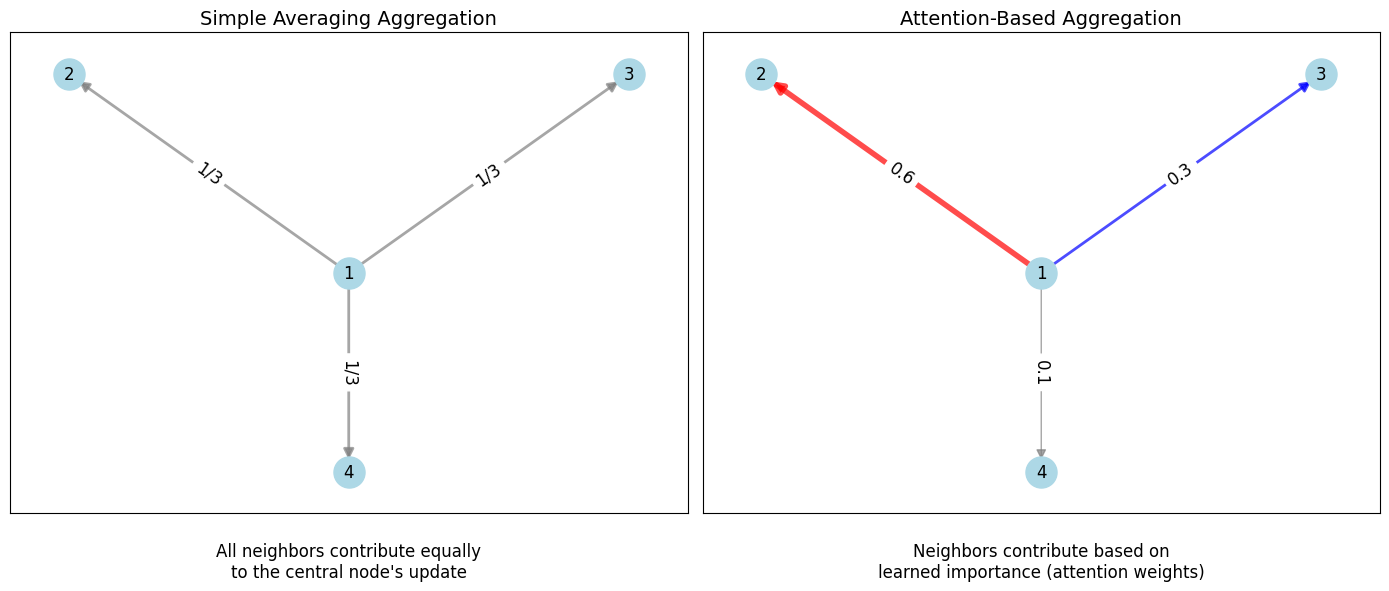

In [9]:
def create_difference_visualization():
    """Create a visual explanation of the difference between averaging and attention"""
    # Create a simple synthetic graph for demonstration
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Example graph layout
    G = nx.DiGraph()
    G.add_nodes_from([1, 2, 3, 4])
    G.add_edges_from([(1, 2), (1, 3), (1, 4)])

    pos = {1: (0.5, 0.5), 2: (0.2, 0.8), 3: (0.8, 0.8), 4: (0.5, 0.2)}

    # Draw averaging aggregation
    ax1.set_title("Simple Averaging Aggregation", fontsize=14)
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, ax=ax1, font_size=12)

    # Draw edges with equal importance
    nx.draw_networkx_edges(G, pos, ax=ax1, width=2.0, alpha=0.7,
                         arrowsize=15, edge_color='gray')

    # Add equal weight labels
    edge_labels = {(1, 2): '1/3', (1, 3): '1/3', (1, 4): '1/3'}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                font_size=12, ax=ax1)

    # Draw attention-based aggregation
    ax2.set_title("Attention-Based Aggregation", fontsize=14)
    nx.draw_networkx_nodes(G, pos, ax=ax2, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, ax=ax2, font_size=12)

    # Draw edges with different widths to represent attention
    nx.draw_networkx_edges(G, pos, ax=ax2,
                         width=[4.0, 2.0, 1.0],
                         edge_color=['red', 'blue', 'gray'],
                         alpha=0.7, arrowsize=15)

    # Add attention weight labels
    edge_labels = {(1, 2): '0.6', (1, 3): '0.3', (1, 4): '0.1'}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                font_size=12, ax=ax2)

    # Add explanation text
    ax1.text(0.5, -0.1, "All neighbors contribute equally\nto the central node's update",
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)

    ax2.text(0.5, -0.1, "Neighbors contribute based on\nlearned importance (attention weights)",
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)

    plt.tight_layout()
    plt.show()

create_difference_visualization()